In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from purplerl.config import device
from purplerl.train_workbook import WorkbenchObsEncoder
from purplerl.workbook_env import WorkbookEnv
from purplerl.policy import StochasticPolicy, ContinuousPolicy, mlp

/home/cthoens/anaconda3/envs/purplerl/lib/python3.10/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
env = WorkbookEnv(sheet_path="/home/cthoens/code/UnityRL/purplerl/sheets")
env.set_lesson(1)
env.reset()
hidden_sizes=[64, 64]
policy= ContinuousPolicy(
    obs_encoder=WorkbenchObsEncoder(),
    hidden_sizes=hidden_sizes,
    action_space = env.action_space
)
value_net = nn.Sequential(
    policy.obs_encoder,
    mlp(list(policy.obs_encoder.shape) + hidden_sizes + [1])
)
checkpoint = torch.load("/home/cthoens/code/UnityRL/purplerl/results/Workbook/phase1/exalted-serenity-157/lesson 1.pt", map_location=device)
policy.load_checkpoint(checkpoint["policy"])
value_net.load_state_dict(checkpoint["policy_updater"]['value_net_state_dict'])

spawn_points = env._get_spawn_points(env.sheet)

In [6]:
sheet = (np.array(env.sheet) + 1.0) / 2.0
vmin = 1000
vmax = -1000
for spawn_point in spawn_points:
    idx = np.unravel_index(spawn_point, env.SHEET_OBS_SPACE.shape)[1:]
    env.steps_left = 1
    env.cursor_pos = idx
    obs = env._get_obs()
    obs = torch.as_tensor(obs.reshape((1,) + obs.shape))
    sheet[idx] = value_net(obs)
    vmin = min(vmin, sheet[idx])
    vmax = max(vmax, sheet[idx])
    
print(f"{vmin:.4f} -> {vmax:.4f}")

0.5682 -> 0.6652


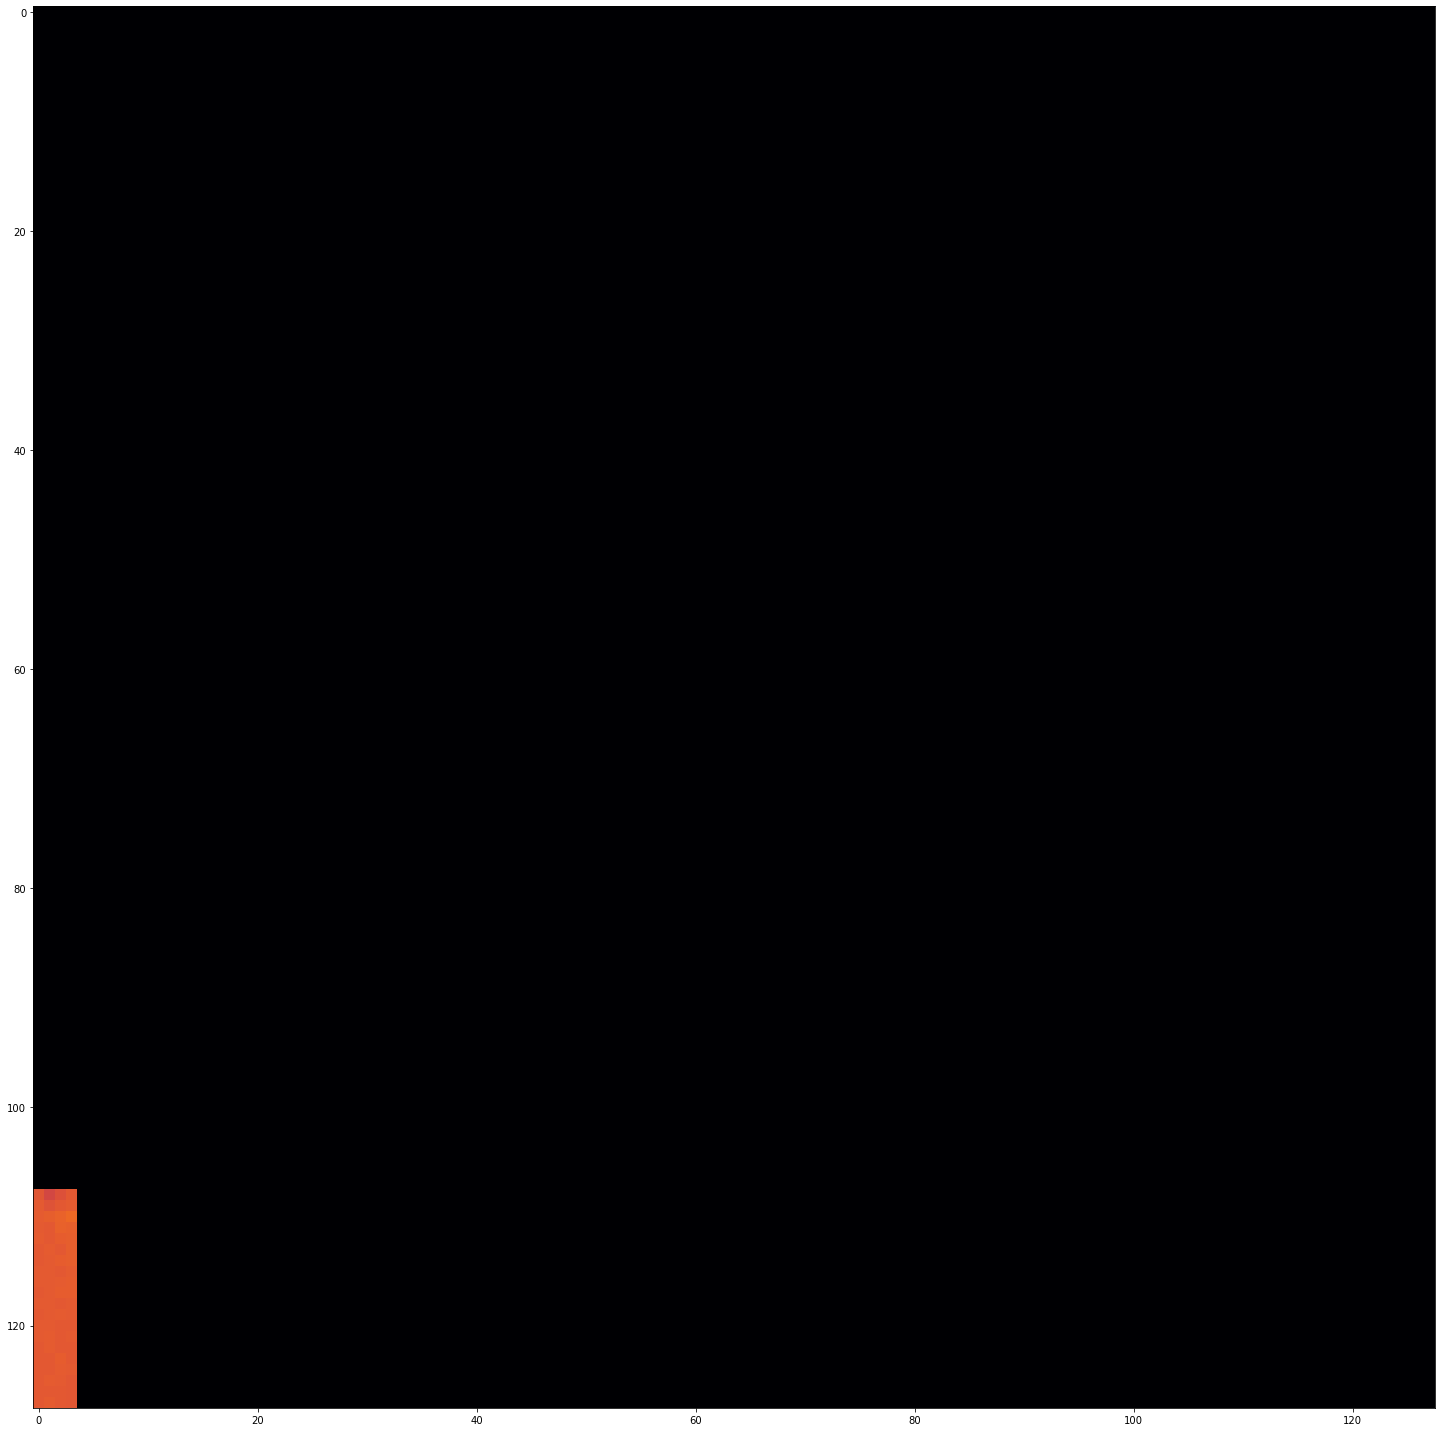

In [7]:
plt.rcParams["figure.figsize"] = [20, 20]
plt.rcParams["figure.autolayout"] = True

plot_img = sheet
plt.imshow(plot_img, cmap='inferno', vmin=0.0, vmax=1.0)

plt.show()

In [ ]:
0.8187 -> 0.9304
0.9106 -> 1.0137